# Data Science Research Methods Report (Length: 3530 words)

## Candidate Number: 213873

# Introduction

In this report our goal is to develop a smartwatch that will be able to give you information about the intensity of your physical activity based on your heart rate. The dataset we used to gain insights is the PAMAP2 Physical Activity Monitoring dataset. Our approach focuses on cleaning the dataset from dirty data such as missing values, columns that are either recommended to be dropped or are not necessary for our goal. After data preprocessing, we continue with visualisation, which contributes to the understanding of the relationships between the attributes and especially between heart rate and the rest attributes. Furthermore, hypothesis testing is conducted, testing three different hypothesis for relationships between activity intensity and heart rate. In the end, the development of a multiple linear regression model will help in the better understanding of the influence that the attributes of the dataset have in value of heart rate, and thus in an accurate prediction of how this value will behave.

# PAMPA2 Dataset

The PAMAP2 Physical Activity Monitoring dataset consists of measurements that come from 18 different physical activities, performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction.


The hardware setup contains:

3 Colibri wireless IMUs (inertial measurement units) were used:
    
    – sampling frequency: 100Hz
    – position of the sensors:
        – 1 IMU over the wrist on the dominant arm
        – 1 IMU on the chest
        – 1 IMU on the dominant side's ankle

HR-monitor: BM-CS5SR from BM innovations GmbH
    
    – sampling frequency: ~9Hz

Companion unit: Viliv S5 UMPC
    
    – Intel Atom Z520 CPU (1.33GHz) and 1GB of RAM
    – labeling the different performed activities was done via a GUI  running on the Viliv


Regarding the subjects, the number of participants in the data collection was 9. Most of them are employees or students at DFKI, with 8 of them being male and one female aged 27.22 ± 3.31 years and with BMI 25.11 ± 2.62 kgm-2.

Following the data collection protocol, each subject had to perform 12 activities with a choice of an extra optional group that contained a wide range of everyday, household and sport activities. This optional group of activities consists 6 different activities in total were performed by some of the subjects in addition to the protocol.

# Data Preprocessing

### Libraries

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score

### Setting column names

In this step we define the column names in order to insert them in the next step when we read every file. By doing this the final dataframe will have the columns names set after the concatenation stage. For the accelerometer, the gyroscope and the magnometer we also added the axis that each column of every device represents.

In [2]:
column_names = ['timestamp','activityID','heart_rate','hand_temperature','hand_acceleration_16g.x','hand_acceleration_16g.y',
                   'hand_acceleration_16g.z','hand_acceleration_6g.x','hand_acceleration_6g.y','hand_acceleration_6g.z','hand_gyroscope.x',
                   'hand_gyroscope.y', 'hand_gyroscope.z','hand_magnetometer.x','hand_magnetometer.y','hand_magnetometer.z',
                   'hand_orientation','hand_orientation.1', 'hand_orientation.2','hand_orientation.3','chest_temperature',
                   'chest_acceleration_16g.x','chest_acceleration_16g.y','chest_acceleration_16g.z','chest_acceleration_6g.x',
                   'chest_acceleration_6g.y','chest_acceleration_6g.z','chest_gyroscope.x','chest_gyroscope.y','chest_gyroscope.z',
                   'chest_magnetometer.x','chest_magnetometer.y','chest_magnetometer.z','chest_orientation','chest_orientation.1',
                   'chest_orientation.2','chest_orientation.3','ankle_temperature','ankle_acceleration_16g.x','ankle_acceleration_16g.y',
                   'ankle_acceleration_16g.z','ankle_acceleration_6g.x','ankle_acceleration_6g.y','ankle_acceleration_6g.z',
                   'ankle_gyroscope.x','ankle_gyroscope.y', 'ankle_gyroscope.z','ankle_magnetometer.x','ankle_magnetometer.y',
                   'ankle_magnetometer.z','ankle_orientation','ankle_orientation.1', 'ankle_orientation.2','ankle_orientation.3']

### Read and concatenate the protocol and the optional data

Firstly, we need to read our data from our folders and in order to do that we built two functions that will help us reading all the .dat files and then concatenate them in one. The first function, read_file(), takes two arguments, the file name and the number of subject and then reads the file directly, converting it to a pandas dataframe adding also one new column named "subject". This column represents the number of subject in the final file. The second function, read_concat(), takes three arguments, the protocol file name, the optional file name and the number of subject. The purpose of this function is to read the protocol and the optional files and then merge them creating one file with all the data of every subject. In the end by using the first function all file are concatenated and converted into one dataframe.

In [3]:
def read_file(file,subject):
    
    # Read file from folder
    df_prot = pd.read_csv(file,header=None, sep='\s\s+|, ', engine='python',delimiter=' ', names = column_names) 
    
    # Add Subject column
    df_prot['Subject'] = subject
    
    return df_prot

In [4]:
def read_concat(protocol_file,optional_file,subject):
    
    #Read file from folder
    df_prot = read_file(protocol_file,subject)
    df_opt = read_file(optional_file,subject)
    
    # Concatenate protocol and optional data file
    df = pd.concat([df_prot,df_opt], ignore_index=True, sort=False)
    
    return df

In [5]:
# Read and concatenate the protocol and the optional files into a subject file
s1 = read_concat('PAMAP2_Dataset\Protocol\subject101.dat','PAMAP2_Dataset\Optional\subject101.dat',1)
s5 = read_concat('PAMAP2_Dataset\Protocol\subject105.dat','PAMAP2_Dataset\Optional\subject105.dat',5)
s6 = read_concat('PAMAP2_Dataset\Protocol\subject106.dat','PAMAP2_Dataset\Optional\subject106.dat',6)
s8 = read_concat('PAMAP2_Dataset\Protocol\subject108.dat','PAMAP2_Dataset\Optional\subject108.dat',8)
s9 = read_concat('PAMAP2_Dataset\Protocol\subject109.dat','PAMAP2_Dataset\Optional\subject109.dat',9)

In [6]:
# Read the protocol files of subjects that have not performed optional activities
s2 = read_file('PAMAP2_Dataset\Protocol\subject102.dat',2)
s3 = read_file('PAMAP2_Dataset\Protocol\subject103.dat',3)
s4 = read_file('PAMAP2_Dataset\Protocol\subject104.dat',4)
s7 = read_file('PAMAP2_Dataset\Protocol\subject107.dat',7)

In [7]:
# Concatenate all the files into one
df = pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9], ignore_index=True, sort=False)

### Drop timestamp, acceleration_6g and orientation columns for hand, chest and ankle data

The next step after constructing our dataframe is preprocessing. We start by dropping some columns that either have no use for us or are recommended for drop by the dataset overview. It is stated that for this dataset 2 different accelerometers were used one with with a scale of ±16g and one with a scale of ±6g. This accelerometer is not precisely calibrated with the first one. Moreover, due to high impacts caused by certain movements (e.g. during running) with acceleration over 6g, it gets saturated sometimes. Therefore, we drop all nine columns for the accelerometer with a scale of ±6g as the data from the first accelerometer (with the scale of ±16g) is recommended. The dataset file also mentions that the orientation columns are invalid in this data collection, and thus we drop all twelve orientation columns for hand, chest and ankle. Furthermore, because the weather conditions were not specified and the data include outdoor activities we decied to drop all three columns of hand,chest and ankle temperature as we feel the data are not representative. Finally, we also dropped the timestamp column as with the concatenation of all files the values of this column were mixed. However, we know that each row represent 0.01 second from the timestamp column and we can recreate it again.

In [8]:
# Drop specific columns
df = df.drop(columns=['hand_acceleration_6g.x', 'hand_acceleration_6g.y', 'hand_acceleration_6g.z','hand_orientation', 'hand_orientation.1', 'hand_orientation.2', 'hand_orientation.3','hand_temperature', 
                      'chest_acceleration_6g.x', 'chest_acceleration_6g.y', 'chest_acceleration_6g.z','chest_orientation', 'chest_orientation.1', 'chest_orientation.2', 'chest_orientation.3','chest_temperature',
                      'ankle_acceleration_6g.x', 'ankle_acceleration_6g.y', 'ankle_acceleration_6g.z','ankle_orientation', 'ankle_orientation.1', 'ankle_orientation.2', 'ankle_orientation.3','ankle_temperature','timestamp'])

### Drop rows with activityID = 0 as designated from the dataset instructions file

In addition to the columns dropped in the previous step, the instructions file of the datset mentions that data labeled with activityID=0 should be discarded in any kind of analysis. This data mainly covers transient activities between performing different activities, e.g. going from one location to the next activity's location, or waiting for the preparation of some equipment. Also, different parts of one subject's recording (in the case when the data collection was aborted for some reason) was put together during these transient activities (noticeable by some “jumping” in the HR-data). By taking in consideration these comments we dropped all rows that had activityID=0.

In [9]:
# Drop rows if activityID value equals 0
df = df[df.activityID != 0]  

### Handle missing values

Another very important step in the stage of data preprocessing is handling missing values. If they are not handled properly, then there is a big possibility that our inference about the data will be inaccurate. There are two ways we can effectively deal with this problem for this specific dataset, removal and linear interpolation for dealing with wireless  heart rate data loss.

There are three main reasons for missing data in this dataset as stated in the readme file. The first one is data dropping due to using wireless sensors. This however only occurred very rarely: the 3 IMUs had a “real” sampling frequency of 99.63Hz, 99.89Hz and 99.65Hz for hand, chest and ankle IMU placement, respectively. The second one is the problems with the hardware setup, causing e.g. connection loss to the dongles or system crash. Due to these problems, some activities for certain subjects are partly or completely missing. The third one is missing sensory data due to wireless data dropping.
Since data is given every 0.01s (due to the fact, that the IMUs have a sampling frequency of 100Hz), and the sampling frequency of the HR-monitor was only approximately 9Hz, the missing HR-values are also indicated with NaN in the data-files.

We approached the problem that the heart monitor caused by implementing linear interpolation for the data missing from the heart rate column. The column had one float value and nine NaN values for every segment of ten. By doing this we were able to keep all of the heart rate column data, as the missing values were 2.476.126 out of the 2.724.953 in total. The other columns also had some missing values, 11.868 for the hand devices, 3.058 for the chest devices and 9.867 for the ankle devices. Those missing values were dropped as there were the result of the first two problems we discussed above. Replacing with the mean or with 0 was not recommended.

In [10]:
# How many values are NaN for each column 
na_values = df.isnull().sum()
# na_values uncomment to print the NaN values

#### Implementing linear interpolation

In [11]:
df['heart_rate']=df['heart_rate'].interpolate()

#### Drop rows with missing values

In [12]:
df = df.dropna()

### Convert activityID values from numbers to labels

After dealing with the missing values we made some changes in the activityID column names in order to be more interpretable. The values were numbers and we replaced those numbers with the actvities described in the dataset description file.

In [13]:
activityID_list = ['lying','sitting','standing','walking','running','cycling', 'Nordic walking','watching TV','computer work',
                   'car driving','ascending stairs','descending stairs','vacuum cleaning','ironing','folding laundry',
                   'house cleaning','playing soccer','rope jumping']

# Replace the number values from activityID with the strings in activityID list 
df['activityID'] = df['activityID'].replace([1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24],activityID_list)

### Add Intensity column

Furthermore, we created a new column that describes the intensity of every avaliable activity of the dataset. These activities are classified as activities with low, moderate and high intensity and are based on the metabolic equivalent of task (MET). Information about the MET of every activity are provided in the description file of the dataset. In the intensity category labelled as light are the activities such as lying, sitting, standing, watching TV, computer work, car driving, ironing, folding laundry with a MET< 3.0, while in the one labelled as moderate are descending stairs, vacuum cleaning, cycling, Nordic walking, walking, house cleaning with a MET between 3.0 and 6.0. Finally in the high intensity category we had only four activities which were playing soccer, rope jumping, running and ascending stairs with MET> 6.0. Activities from the optional data files were not included in the instructions file so we filled those values according to https://golf.procon.org/met-values-for-800-activities/. 

Below we create three lists, each for every category and a function named intensity() which reads the activity from activityID column and then returns in the intensity column the category each activity is in.

In [14]:
# Create a list for every category
low_intensity_list = ['lying','sitting','standing','watching TV','computer work','car driving','ironing','folding laundry']
moderate_intensity_list =['descending stairs','vacuum cleaning','cycling', 'Nordic walking','walking','house cleaning']
high_intensity_list = ['playing soccer','rope jumping','running','ascending stairs']

In [15]:
def intensity(activity):   
    
    if activity in low_intensity_list:
        return 'low'
    elif activity in moderate_intensity_list:
        return 'moderate'
    elif activity in high_intensity_list:
        return 'high'

In [16]:
# Implementing the intensity function
df['Intensity'] = df['activityID'].apply(intensity)

# Visualisation

Our next step after data preprocessing is visualisation. With visualisation our goal is to have a better understanding of the data by detecting patterns, trends and outliers in them. As heart rate is our basic category of interest, we focused on exploring the relationship between heart rate and categories such as 'Subject' and 'Intensity' using barplot boxplots and histograms. With the barplots visualised the amount of time every Subject was active and the total amount of every activity while with boxplots we visualised the distribution of data based on median,quartiles and outliers. Regarding outliers, we wanted to see if they distort the true picture or can help us in detecting an anomaly.Finally with histograms our goal was to see if the data were normally distributed.

### Barplot  for  the time each subject spend in activities and for the time each activity was executed


The two barplots below depict the amount of time spent in activities for every subject individually but also the total amount of time spent in every activity. We can represent seconds of an activity by taking the number of rows and dividing them by 0.01 as every row represent 0.01 second and then convert them to minutes by furhter diving with 60. For example 6000 rows of activity 'walking' correspond in 60 second or 1 minute of walking.  

So, in the first barplot on the left we can see how much time every subject was active during the day. Almost half of our subjects (1,5,6,8) were active for more than 60 minutes while all the others(2,3,4,7,9) were active between 27 and 47 minutes. The average time a subject spend on activitie was 50 minutes. 

On the right side we can see how the time was distributed between all activities. More casual activities like computer work (>50 minutes), walking (>35 minutes), standing and lying (both > 30 minutes) were more popular amongst the subjects scoring a high number of minutes. On the other hand, playing soccer and rope jumping were not the first choice with both being bellow the 10 minutes mark.

** In the left barplot on the x Axis, there is a bug where the diagram does not depict all the numbers.

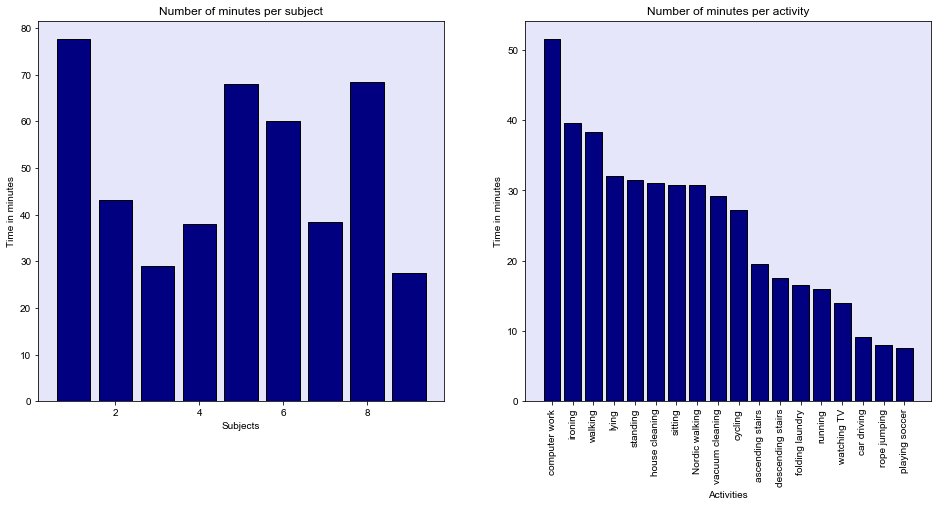

In [17]:
plt.rcParams["figure.figsize"] = [16,7]
fig, ax = plt.subplots(1, 2)
sns.set(style="whitegrid")
sns.axes_style("darkgrid")

# Create subset for Subject
subject_count =df.loc[:,['Subject','heart_rate']].groupby('Subject')['heart_rate'].count()*0.01/60
subject = subject_count.reset_index(name='subject count').sort_values(['subject count'], ascending=False)

# Create barplot
ax[0].bar(subject['Subject'], subject['subject count'], color = 'navy', edgecolor='black')
ax[0].set_facecolor("lavender")
ax[0].set_title('Number of minutes per subject')
ax[0].set_xlabel('Subjects')
ax[0].set_ylabel('Time in minutes')


# Create subset for activity
activity_count =df.loc[:,['activityID','heart_rate']].groupby('activityID')['heart_rate'].count()*0.01/60
activity = activity_count.reset_index(name='activities count').sort_values(['activities count'], ascending=False)

# Create barplot
ax[1].bar(activity['activityID'], activity['activities count'], color = 'navy', edgecolor='black')
ax[1].set_xticklabels(activity['activityID'], rotation=90)
ax[1].set_facecolor("lavender")
ax[1].set_title('Number of minutes per activity')
ax[1].set_xlabel('Activities')
ax[1].set_ylabel('Time in minutes')

plt.show()

### Boxpot Heart rate vs Subjects


The boxplot below depicts the relationship between the Subjects and the heart rate. From a first look we can detect a big number of outliers in most of our subjects. However there is a different interpretation of these outliers. They represent a short timed activity that caused the heart rate of the subject either to go extremely high or low in comparison with all the other activities that this specific subject performed. For example subject 9 spend a lot of time working on computer and folding laundry(low intensity) but also spend a considerable smaller amount of time playing soccer and performing rope jumping. This behaviour led to the boxplot below. Although it is not the only case that has that type of behaviour, it is the most extreme. Subjects 1,4,5,6 and 8 follow same pattern with the rest not showing these behaviour. The median of most of the subjects were 85 and 110 beats per second. In the histograms these outliers can be intepreted as skewness.

Text(0.5, 1.0, 'Subjects vs Heart Rate')

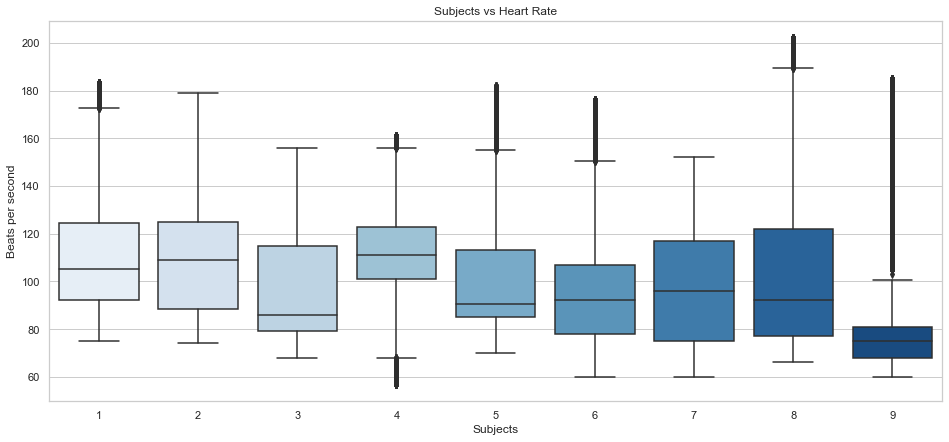

In [18]:
# Create Boxplot
sns.set(style="whitegrid")
sns.boxplot( x=df["Subject"], y=df["heart_rate"], palette="Blues")

plt.xlabel("Subjects")
plt.ylabel("Beats per second")
plt.title("Subjects vs Heart Rate")

### Histogram of beats per second for every subject

Boxplot offer us a specific view of the data distribution. That is why we also visualised the heart rate of every subject using histograms as we can see below. From a first look the data derived from every subject are clearly not normally distributed. If we want to verify we can perform a normality check. There are many tests available to verify normality. Shapiro-Wilk test is one but is not recommended for a large amount of data such ours. The one we implemented in a later stage is the "stats.normaltest" from scipy library. The null hypothsesis of this test is that a sample comes from a normal distribution and it has it's basis on the D'Agostino and Pearson's test that combines skew and kurtosis to produce an omnibus test of normality.


** Due to the structure of the package only the bottom three graphs show tha values of x Axis. However, these values apply in all diagrams meaning that the X axis of every histogram below is between 0 and 210 beats per second.

Text(0.5, 1.0, 'Heart Rate for Subject 9')

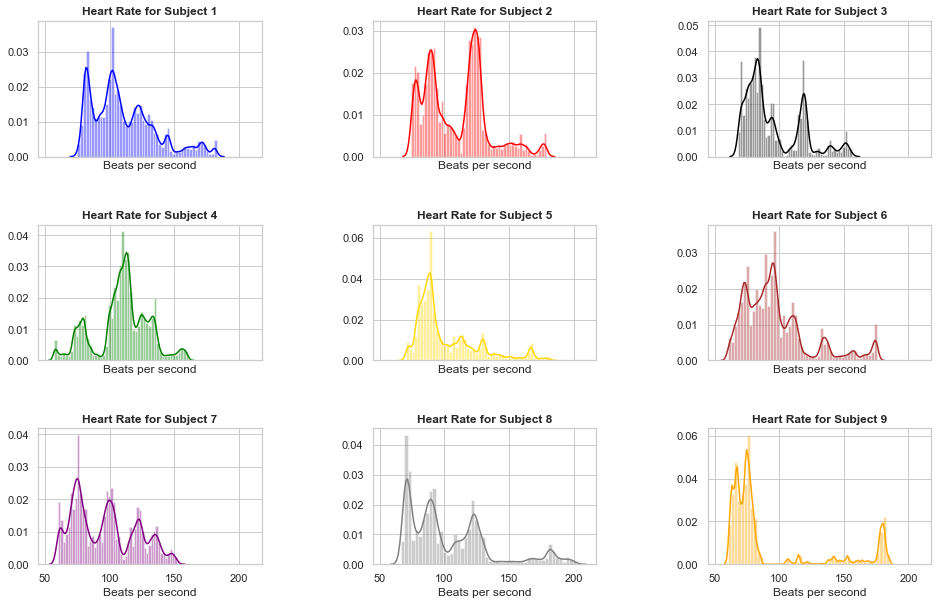

In [20]:
f, axes = plt.subplots(3,3, figsize=(16, 10), sharex=True)

# Adjusting the space between the diagrams
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

# Create multiple histograms
sns.distplot(df.loc[(df.Subject == 1)]['heart_rate'],color="blue",axlabel='Beats per second', ax=axes[0, 0]).set_title('Heart Rate for Subject 1',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 2)]['heart_rate'],color="red",axlabel='Beats per second', ax=axes[0, 1]).set_title('Heart Rate for Subject 2',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 3)]['heart_rate'],color="black",axlabel='Beats per second', ax=axes[0, 2]).set_title('Heart Rate for Subject 3',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 4)]['heart_rate'],color="green",axlabel='Beats per second', ax=axes[1, 0]).set_title('Heart Rate for Subject 4',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 5)]['heart_rate'],color="gold",axlabel='Beats per second', ax=axes[1, 1]).set_title('Heart Rate for Subject 5',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 6)]['heart_rate'],color="brown",axlabel='Beats per second', ax=axes[1, 2]).set_title('Heart Rate for Subject 6',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 7)]['heart_rate'],color="purple",axlabel='Beats per second', ax=axes[2, 0]).set_title('Heart Rate for Subject 7',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 8)]['heart_rate'],color="grey",axlabel='Beats per second', ax=axes[2, 1]).set_title('Heart Rate for Subject 8',fontweight='bold')
sns.distplot(df.loc[(df.Subject == 9)]['heart_rate'],color="orange",axlabel='Beats per second', ax=axes[2, 2]).set_title('Heart Rate for Subject 9',fontweight='bold')

### Boxplot of Heart rate vs Intensity

The boxplot below depicts the relationship between the heart rate and the Intensity category. As the activities are large in number it is more convenient to use the Intensity category to represent themwhere are grouped in low,moderate and high intensity.

For the low intensity group there is a very small number of outliers that is caused probably from an unexpected situations during one or more activities as it is very unusual for people performing these activities to reach heart rate above 130, especially with an Inter Quartile Range being between 70 and 90 beta per second(bps). The median is 82 beats per second.

For the moderate intensity group there is again a very small amount of outliers that is maybe caused from an activity that has a little higher heart rate than all the others of this category. The IQR is between 100 and 125 bps while the median is 115 bps.

For the high intensity group there are no outliers, with the IQR being between 130 and 175 bps while the median is 152.

Text(0.5, 1.0, 'Heart Rate vs Intensity')

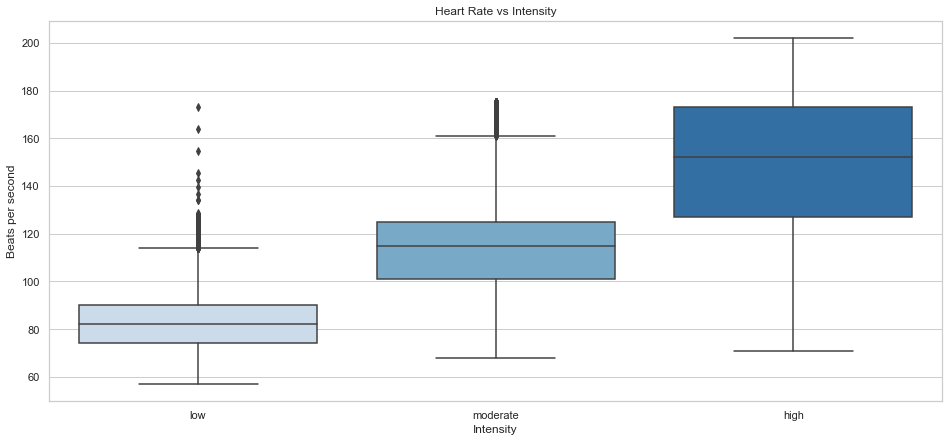

In [21]:
# Create boxplot
sns.set(style="whitegrid")
sns.boxplot( x=df["Intensity"], y=df["heart_rate"], palette="Blues")

plt.xlabel("Intensity")
plt.ylabel("Beats per second")
plt.title("Heart Rate vs Intensity")

### Histograms of Heart rate vs Intensity groups

After the boxplots we also visualised those two columns using histograms. The upper left histogram with the blue color depicts the data distribution of all the heart rate category while the other three are for each intensity group. It seems that none of these data distributions follow a normal distribution. However we implemented the normality test we mentioned above to validate our assumptions about the histograms referring to moderate and low intensity. We built a function that takes the data we want to test and the a text for the printing part and returns the printed results including the statistic and the p-value.
The results return a very small p-value, lower that 0.05, meaning that we reject the null hypothesis that these distributions follow a normal distribution. The p-value was so small that the python language returned 0.0 when actually is a very small number near 0.

** For the histograms below the same condition applies for values in the X axis  

Text(0.5, 1.0, 'Beats per second distribution for low intensity')

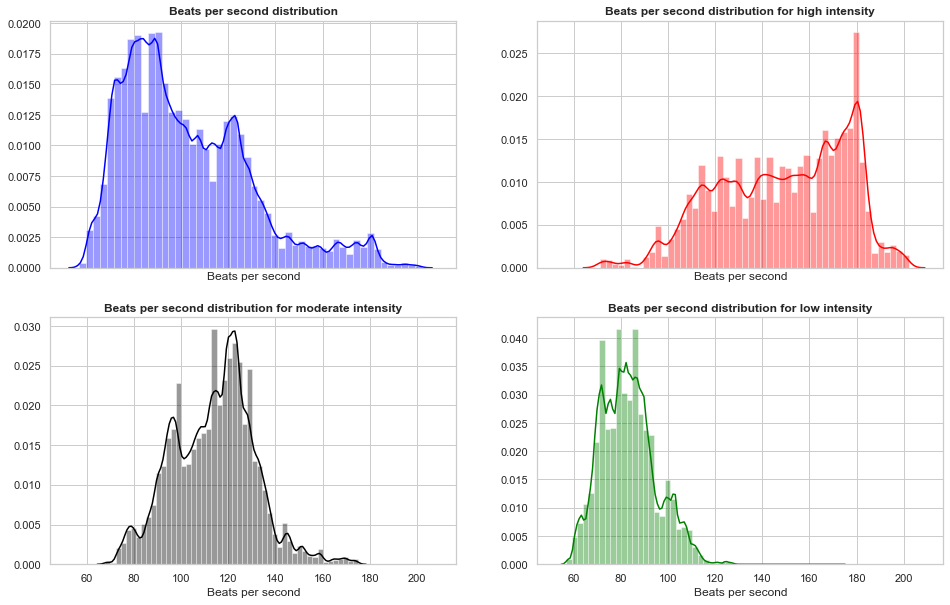

In [22]:
f, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# Create multiple histograms
sns.distplot(df['heart_rate'],color="blue",axlabel='Beats per second', ax=axes[0, 0]).set_title('Beats per second distribution',fontweight='bold')
sns.distplot(df.loc[(df.Intensity == 'high')]['heart_rate'],color="red",axlabel='Beats per second', ax=axes[0, 1]).set_title('Beats per second distribution for high intensity',fontweight='bold')
sns.distplot(df.loc[(df.Intensity == 'moderate')]['heart_rate'],color="black",axlabel='Beats per second', ax=axes[1, 0]).set_title('Beats per second distribution for moderate intensity',fontweight='bold')
sns.distplot(df.loc[(df.Intensity == 'low')]['heart_rate'],color="green",axlabel='Beats per second', ax=axes[1, 1]).set_title('Beats per second distribution for low intensity',fontweight='bold')

#### Normality Tests for the four histograms above

In [23]:
def normality_test(data,intensity):
    
    test = stats.normaltest(data)
    print('The normality test for {} returned: {}'.format(intensity,test))

In [24]:
high_int = df.loc[(df.Intensity == 'high')]['heart_rate']
mod_int = df.loc[(df.Intensity == 'moderate')]['heart_rate']
low_int = df.loc[(df.Intensity == 'low')]['heart_rate']

normality_test(df['heart_rate'],'heart rate attribute')
normality_test(high_int,'high intensity')
normality_test(mod_int,'moderate intensity')
normality_test(low_int,'low intensity')

The normality test for heart rate attribute returned: NormaltestResult(statistic=325639.58088244364, pvalue=0.0)
The normality test for high intensity returned: NormaltestResult(statistic=30335.86477335036, pvalue=0.0)
The normality test for moderate intensity returned: NormaltestResult(statistic=2439.8251101688606, pvalue=0.0)
The normality test for low intensity returned: NormaltestResult(statistic=42410.93352249318, pvalue=0.0)


# Hypothesis Testing

As the intensity category represents three groups of activities that have different MET value (low intensity < 3.0 MET, moderate intensity between 3.0 and 6.0 MET and high intensity > 6.0 MET, our goal was to see if also the difference in heart rate is significant between these groups. We conducted three hypothesis tests between the 3 populations. The population of heart rate values that is referring to "high" intensity, the population of heart rate values that is referring to "moderate" intensity and the the population that is refrerring to "low" intensity.

Earlier, with the help of visualisation and more specifically the histograms we found out that the distribution of the heart rate category does not follow the normal distribution in any case. Because of that we could not perform a t-test. However, there was another test that we implemented to test our hypothesis, the Mann-Whitney U test which is a non-parametric test. 

The null hypothesis is that there is an equal chance that a randomly selected observation from one population will be greater than or less than a randomly selected observation from the second population. 

The alternative hypothesis is that a randomly selected observation from one population will not the same chance to be less than or greater than  a randomly selected observation from the second population. That means that our alternative hypothesis assumes that one variable tends to have higher values than the other.

We tested implemented the tests in three different pairs:

1st pair: heart rate for high intensity and heart rate for moderate intensity

2nd pair: heart rate for high intensity and heart rate for low intensity

3rd pair: heart rate for moderate intensity and heart rate for low intensity

In [25]:
high_int_data = df[df['Intensity'] == 'high']
hr_high = high_int_data['heart_rate']

mod_int_data = df[df['Intensity'] == 'moderate']
hr_mod = mod_int_data['heart_rate']

low_int_data = df[df['Intensity'] == 'low']
hr_low = low_int_data['heart_rate']

### Test no.1 : Heart Rate of High vs Moderate intensity

In [26]:
high_v_mod_int_ttest = stats.mannwhitneyu(hr_high,hr_mod, use_continuity=True, alternative='two-sided')
print(high_v_mod_int_ttest)
print("Heart rate median for high intensity: {}".format(hr_high.median()))
print("Heart rate median for moderate intensity: {}".format(hr_mod.median()))

MannwhitneyuResult(statistic=270212640889.5, pvalue=0.0)
Heart rate median for high intensity: 152.0
Heart rate median for moderate intensity: 115.0


### Test no.2 : Heart Rate of High vs Low intensity

In [27]:
high_v_low_int_ttest = stats.mannwhitneyu(hr_high,hr_low, use_continuity=True, alternative='two-sided')
print(high_v_low_int_ttest)
print("Heart rate median for high intensity: {}".format(hr_high.median()))
print("Heart rate median for low intensity: {}".format(hr_low.median()))

MannwhitneyuResult(statistic=407906285264.5, pvalue=0.0)
Heart rate median for high intensity: 152.0
Heart rate median for low intensity: 82.0


### Test no.3 : Heart Rate of Moderate vs Low intensity

In [28]:
mod_v_low_int_ttest = stats.mannwhitneyu(hr_mod,hr_low, use_continuity=True, alternative='two-sided')
print(mod_v_low_int_ttest)
print("Heart rate median for moderate intensity: {}".format(hr_mod.median()))
print("Heart rate median for low intensity: {}".format(hr_low.median()))

MannwhitneyuResult(statistic=1305244197138.0, pvalue=0.0)
Heart rate median for moderate intensity: 115.0
Heart rate median for low intensity: 82.0


### Results

All of our tests scored a p value very close to zero, smaller than 0.05, rejecting the null hypothesis in any case and accepting the alternative. Again the values were so close to 0 that python returned 0.0. 


By conducting these tests we proved that the difference in heart rate values between the three categories in the Intensity variable is significant. Before we have constructed Intensity category by using MET values that were given and now he have verified these results by proving that not only the MET values are different between the categories but also the heart rate values.

# Modelling

The goal we want to achieve here is see to how much a group of variables within our dataset influence the heart rate of a subject. A reasonable approach is perform regression analysis to examine such relationships. In our case we built a multiple linear regression model with our dependend variable being heart rate and the independent variables being all the other attributes.

### Multiple Linear Regression

Our model focuses on examining how the data from the all the attributes influence heart rate value. For that reason we  converted the activityID and Intensity column from string to numbers. We continued by defining the dependent and independent variables, splitting the data, fitting them in the linear regression model and calculating the coefficients. In the end we also calculated regression metrics like RMSD (root mean square deviation) and the R squared.

In [29]:
activityID_bps_sorted = ['lying','computer work','sitting','watching TV','standing',
                         'ironing','folding laundry','house cleaning','car driving','vacuum cleaning',
                         'walking','Nordic walking','cycling','descending stairs','ascending stairs','running',
                         'rope jumping','playing soccer']

intensity_list = ['low','moderate','high']

# Convert columns from strings to numbers
df['activityID'] = df['activityID'].replace(activityID_bps_sorted,[1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24])
df['Intensity'] = df['Intensity'].replace(intensity_list,[1,2,3])


# Define the dependent variable y and the group of independent X
X = df.drop(columns='heart_rate')
y = df['heart_rate']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Fit the data in the Linear Regression model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# Calculate the coefficients
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
activityID,3.679534
hand_acceleration_16g.x,-0.026854
hand_acceleration_16g.y,-0.092531
hand_acceleration_16g.z,-0.097629
hand_gyroscope.x,0.148335
hand_gyroscope.y,0.458863
hand_gyroscope.z,-0.056006
hand_magnetometer.x,-0.014896
hand_magnetometer.y,0.008532
hand_magnetometer.z,0.009021


In [30]:
# Calculate the predicted values
y_pred = regressor.predict(X_test)

# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('R^2:', r2_score(y_test, y_pred))   
print('Root Mean Square Deviation:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.7790065210228296
Root Mean Square Deviation: 12.85900563348001


### Results

The table above depicts the coefficients of our multiple linear regression model. A positive coefficient value indicates that as the independent variable increases the dependent variable also increases and if it decreases the dependent variable decreases too. In this case 12 independent variable coefficients are positive with the highest being "activityID" with  a coefficient value of 3.679534. That means that for one unit that "activityID" increases, the heart rate or dependent variable also increases by 3.679534. The other 18 coefficients are negative with lowest one being "Subject" with a value of -1.672316. That means that for one unit that "Subject" decreases, the heart rate or dependent variable also decreases by -1.672316.


We also calculated the RMSD (Root Mean Square Deviation) and the R squared. As RMSD represents the square root of the second sample moment of the differences between predicted values and observed values, a value of 12.859 is not very good. Furthermore, R-Squared value was 0.77 meaning that the independent variables represent the 77% of the proportion of the variance for the dependent variable.


Our results were not the best possible, meaning that our model does not fit very well in our data. There are some reasons that might played a role in this such as the huge number of observations or the outliers (RMSD is sensitive to outliers). One approach could have been to segment the data and test again the model in a smaller sample, or try a polynomial regression.

# Conclusion

Reaching at the end of our analysis our main objectives have been met. Our goal was to extract meaningful information for the development of a smartwatch intensity and activity tracker device that. We started merging all the data files from all subjects into one and continued by cleaning the dataframe from unecessary or missing features and creating a new column named "Intensity" that grouped the activities in respect with the MET values. Moreover, visualisation of the clean data helped us to understand better the underlying patterns with our attributes of interest being the heart rate, Subject and Intensity columns. We continued with the hypothesis testing where we verified that the difference between the different groups of the Intensity column is significant by rejecting the null hypothesis. In the end, a multiple linear regression model was developed to help us in the analysis of the impact that our had in the fluctuation of the heart rate value and therefore in making meaningful predictions. For future work, different and more complex models could be developed that include both classification and regression.